In [1]:
# https://github.com/keras-team/keras/blob/master/examples/reuters_mlp.py
'''Trains and evaluate a simple MLP
on the Reuters newswire topic classification task.
'''
from __future__ import print_function

import numpy as np
import keras
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, Input, Reshape, Concatenate, Flatten
from keras.layers import Conv1D, Conv2D, GlobalMaxPooling1D, MaxPooling1D, MaxPool2D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


{'political': 3, 'misc': 2, 'violence/terrorism': 1}


0    syrian assad say syria killed damascus people ...
1    use osc copyrighted_material dissemination usa...
2    will year can people one country party make sa...
3    quot apos say the we it reuters terrorists ass...
4    baghdad iraq sunni killed bomb iraqi attacks w...
Name: topicFlat, dtype: object

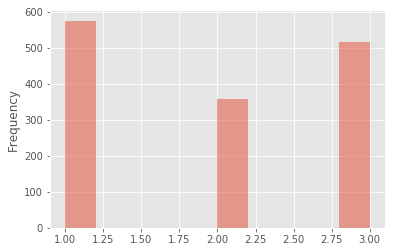

In [2]:
data_train = pd.read_csv('result_all_windows_labels.csv')

# Cleanup - remove no labels
data_train = data_train[data_train['label'].notnull()]
data_train = data_train[data_train.label != 'environmental']
data_train = data_train[data_train.label != 'religious']
data_train = data_train[data_train.label != 'economical']


label_cat = {'violence/terrorism' : 1, 'misc': 2, 'political': 3, 
#              'religious': 4, 'economical': 5, 'environmental': 6
            }
print(label_cat) 


def to_category(x):
    return label_cat[x]

data_train['target'] = data_train.apply(lambda row: to_category(row['label']), axis=1)


data_train['target'].plot.hist(alpha=0.5)


texts = []
# Get corpus by joining all keywords
for index, row in data_train.iloc[ :, 2:32].iterrows():
    texts.append(u' '.join(row.tolist()))
    
data_train['topicFlat'] = texts

# texts = datdata_traina_train['topicFlat']
# labels = data_train['target']

# print(labels)
data_train['topicFlat'].head()


In [3]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [4]:
max_words = 100


print('Loading data...')
# (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
#                                                          test_split=0.2)

# X = data_train['topicFlat'].values
Y = pd.get_dummies(data_train['label']).values
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_train['topicFlat'].values)
X = tokenizer.texts_to_sequences(data_train['topicFlat'].values)
print(X[0])
X = pad_sequences(X, maxlen=max_words)
print(X[0])

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, 
                                                    random_state = 42)

print(y_train[100])
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = y_train.shape[1]
print(num_classes, 'classes')

# print('Vectorizing sequence data...')
# x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
# x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Converted class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Loading data...
[4, 17, 1, 2, 16, 42, 7, 47, 56, 30, 8, 22, 38, 12, 10, 3, 17, 82]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  4 17  1  2 16 42  7 47 56 30  8 22 38 12
 10  3 17 82]
[0 0 1]
(1159, 100) (1159, 3)
(290, 100) (290, 3)
1159 train sequences
290 test sequences
3 classes
x_train shape: (1159, 100)
x_test shape: (290, 100)
Converted class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (1159, 3)
y_test shape: (290, 3)


Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 26,627
Trainable params: 26,627
Non-trainable params: 0
_________________________________________________________________
None
Train on 1159 samples, validate on 290 samples
Epoch 1/50
1159/1159 [==============================] - 0s 84us/step

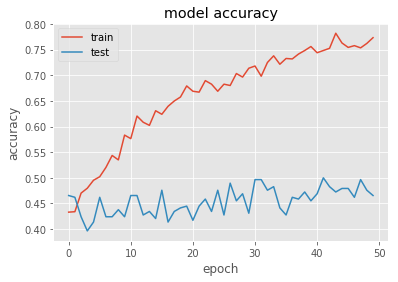

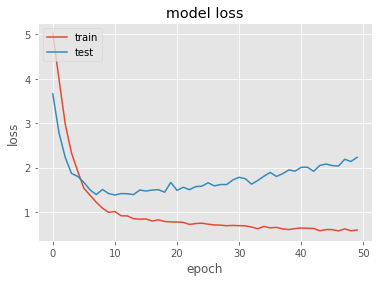

CPU times: user 10.6 s, sys: 660 ms, total: 11.3 s
Wall time: 14.3 s


In [5]:
%%time

# doesnt get better than random guess

batch_size = 10
epochs = 50

print('Building model...')
model = Sequential()
model.add(Dense(256, input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

network_hist = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)


print('Test score:', score[0])
print('Test accuracy:', score[1])

plot_history(network_hist)

Build LSTM model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 1,411,971
Trainable params: 1,411,971
Non-trainable params: 0
_________________________________________________________________
None
Train...
Train on 1159 samples, validate on 290 samples
Epoch 1/10
1159/1159 [==============================] - 86s 74ms/step - loss: 0.8603 - acc: 0.5858 - val_loss: 0.6511 - val_acc: 0.7448
Epoch 2/10
1159/1159 [==============================] - 86s 74ms/step - loss: 0.6298 - acc: 0.7455 - val_loss: 0.5609 - val_acc: 0.7724
Epoch 3/10
1159/1159 [=====================

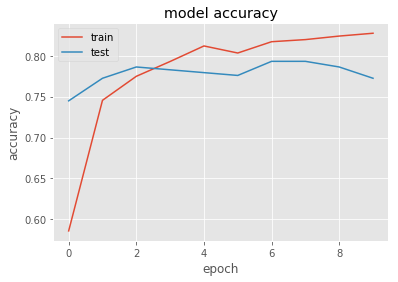

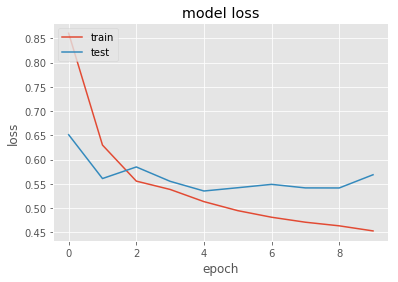

CPU times: user 13min 14s, sys: 1min 7s, total: 14min 22s
Wall time: 14min 23s


In [6]:
%%time

# https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py

max_features = 10000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
epochs = 10

print('Build LSTM model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='sigmoid'))

# try using different optimizers and different optimizer configs
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

print(model.summary())

print('Train...')
network_hist = model.fit(x_train, y_train, 
                         batch_size=batch_size, epochs=epochs,
                         verbose=1, validation_data=(x_test, y_test),
                         validation_split=0.2)


score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 250)           75250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 250)               0     

Epoch 50/50
290/290 [==============================] - 0s 1ms/step
Test score: 1.8663168551593061
Test accuracy: 0.7689655172413793
dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])


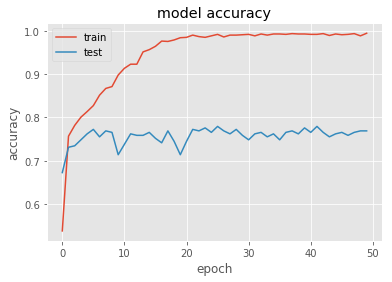

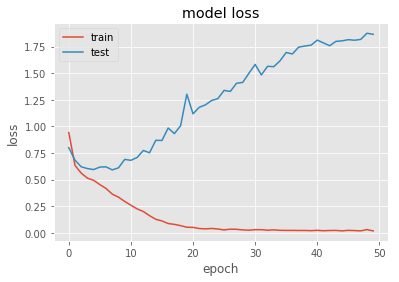

CPU times: user 7min 51s, sys: 7min 3s, total: 14min 55s
Wall time: 4min 13s


In [7]:
%%time

# https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py

# set parameters:
max_features = 10000
maxlen = x_train.shape[1]
batch_size = 32
embedding_dims = 100
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 50


print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

print(model.summary())


print('Training...')
network_hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs, validation_split=0.2,
          validation_data=(x_test, y_test))


score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 213       
_________________________________________________________________
activation_5 (Activation)    (None, 3)                 0     

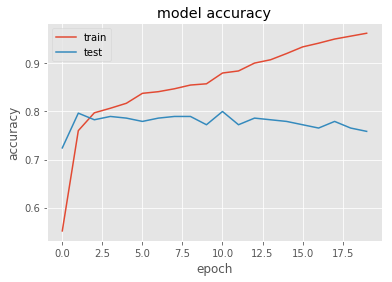

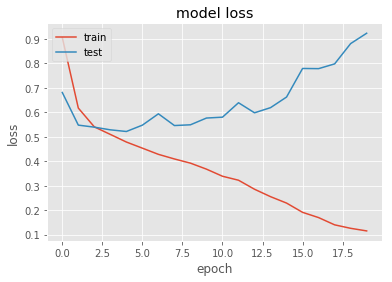

CPU times: user 5min 17s, sys: 6min 11s, total: 11min 28s
Wall time: 3min 27s


In [8]:
%%time

# https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py

maxlen = x_train.shape[1]
# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 10
epochs = 20

print('Build model...')

model = Sequential()
model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

print(model.summary())

print('Train...')
network_hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs, validation_split=0.2,
          validation_data=(x_test, y_test))

score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

Found 6077 unique tokens.
Creating Model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 100)     607700      input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 100, 1)  0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 98, 1, 512)   154112      reshape_1[0][0]                  
_________________________________________________________________

1159/1159 [==============================] - 20s 17ms/step - loss: 0.5234 - acc: 0.8085 - val_loss: 0.5920 - val_acc: 0.7724
Epoch 18/20
1159/1159 [==============================] - 19s 16ms/step - loss: 0.5097 - acc: 0.8188 - val_loss: 0.5875 - val_acc: 0.7655
Epoch 19/20
1159/1159 [==============================] - 20s 17ms/step - loss: 0.5013 - acc: 0.8145 - val_loss: 0.5815 - val_acc: 0.7690
Epoch 20/20
290/290 [==============================] - 1s 4ms/step
Test score: 0.5760835799677618
Test accuracy: 0.7689655176524458
dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])


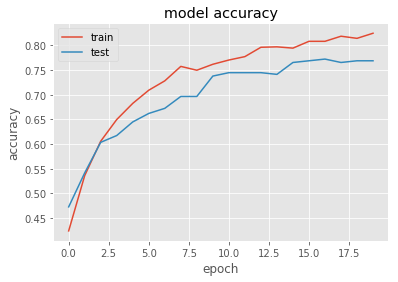

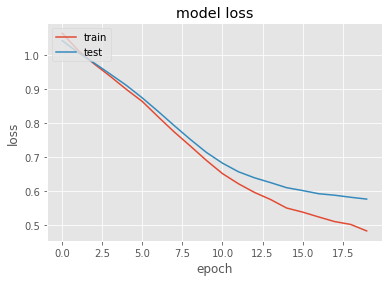

CPU times: user 15min 22s, sys: 11min 8s, total: 26min 30s
Wall time: 7min 5s


In [9]:
%%time

# https://github.com/bhaveshoswal/CNN-text-classification-keras/blob/master/model.py

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index)) # all the tokens in corpus

sequence_length = X.shape[1] # 56
vocabulary_size = len(word_index) # 18765
embedding_dim = 100
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5

epochs = 20
batch_size = 30

# this returns a tensor
print("Creating Model...")
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=num_classes, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', 
                             monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

print("Traning Model...")
network_hist = model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=epochs, verbose=1, callbacks=[checkpoint], 
          validation_data=(x_test, y_test))  # starts training


score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)


(1159, 100)
100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 32)           9632      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 32)           3104      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 32)           3104      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 100, 32)           3104      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 100, 32)           2080 

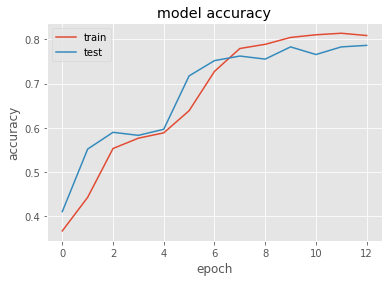

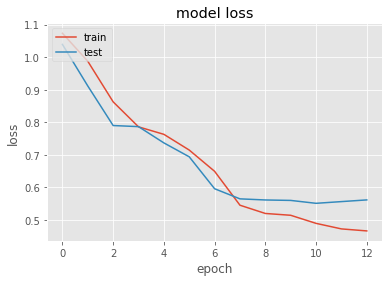

In [10]:
# Keras convolutional model
batch_size = 32
nb_epochs = 20
print(x_train.shape)
maxlen = 100
print(maxlen)
embedding_dim = 100 # embeding dimension
max_features = 10000

model = Sequential()
model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Dropout(0.25))

model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))


model.add(Dense(units=num_classes, activation='softmax'))

adam = Adam(lr=0.0001, decay=1e-6)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

print(model.summary())

print('Training...')
# Fit the model
network_hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(x_test, y_test),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)])


score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)